In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from tqdm import tqdm
import csv
import time


### Get salary data

In [2]:
# os.makedirs('espn_salaries', exist_ok=True)
# for year in tqdm(range(2000, 2024)):
#     cur_s = pd.DataFrame()
#     for page in tqdm(range(1, 16)):
#         cur_page_s = None
#         for trial in range(3):
#             if cur_page_s is not None:
#                 continue
#             try:
#                 time.sleep(5)
#                 cur_page_s = pd.read_html(f'https://www.espn.com/nba/salaries/_/year/{year+1}/page/{page}')[0]
#                 cur_s = pd.concat([cur_s, cur_page_s])
#             except:
#                 pass
#             if trial == 2:
#                 print(f'Failed to get {year+1} page {page}')
#     cur_s.to_csv(f'espn_salaries/salary_{year}.csv', index=False)


# os.makedirs('new_salaries', exist_ok=True)
# for year in tqdm(range(2000, 2024)):
#     time.sleep(3)
#     pd.read_html(f"https://hoopshype.com/salaries/players/{year}-{year+1}/")[0].to_csv(f"new_salaries/salary_{year}.csv", index=False)     

### Get Player Data

In [3]:
# os.makedirs('new_data', exist_ok=True)
# for year in tqdm(range(2000, 2023)):
#     pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year + 1}_totals.html')[0].to_csv(f'new_data/player_{year}.csv', index=False)

### Preprocess Players Data

In [4]:
def process_year(year):

    # load data
    data = pd.read_csv(f'new_data/player_{year}.csv')

    # get rid of unnecessary rows
    data = data[(data['Player'] != 'Player') & (data['Pos'] != 'Pos')]

    # set season
    
    data['Season'] = year
    data['Trend'] = year - 2000

    first_column = data.pop('Season')
    data.insert(0, 'Season', first_column) 

    # convert data types to float
    convert_dict = {col: float for col in ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
        '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
        'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
        }
    data = data.astype(
        convert_dict
        
    )

    # subtract points made from 3 from total points
    data['PTS'] = data['PTS'] - 3* data['3P']

    # drop duplicated rows for players who played for multiple teams, keep the last team they played for
    data = data.sort_values(by='G', ascending=False)
    data = data.drop_duplicates(subset='Player')
    data.reset_index(drop=True, inplace=True)



    game_played_thredhold = data.groupby('Tm').max()['G'].to_dict()

    # drop players who played less than 1/4 of the player who played the most games for that team
    for team in game_played_thredhold:
        data = data[~((data['Tm'] == team) & (data['G'] < game_played_thredhold[team]/4))]


    return data

In [5]:
players = pd.DataFrame()
for year in tqdm(range(2000, 2023)):
    cur_year = process_year(year)
    players = pd.concat([players, cur_year], ignore_index=True, axis=0)
players

100%|██████████| 23/23 [00:00<00:00, 54.58it/s]


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Trend
0,2000,191,Mark Jackson,PG,35.0,TOT,83.0,82.0,2588.0,244.0,...,63.0,242.0,305.0,661.0,84.0,7.0,175.0,139.0,421.0,0
1,2000,119,LaPhonso Ellis,PF,30.0,MIN,82.0,5.0,1948.0,298.0,...,199.0,295.0,494.0,93.0,67.0,74.0,108.0,290.0,751.0,0
2,2000,427,Alvin Williams,SG,26.0,TOR,82.0,34.0,2394.0,330.0,...,50.0,162.0,212.0,407.0,123.0,26.0,103.0,171.0,703.0,0
3,2000,353,Rodney Rogers,SF,29.0,PHO,82.0,3.0,2183.0,377.0,...,94.0,265.0,359.0,180.0,97.0,47.0,157.0,269.0,830.0,0
4,2000,419,Clarence Weatherspoon,PF,30.0,CLE,82.0,82.0,2774.0,347.0,...,223.0,573.0,796.0,103.0,85.0,105.0,112.0,171.0,924.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9244,2022,50,Brandon Boston Jr.,SF,21.0,LAC,22.0,1.0,248.0,51.0,...,7.0,23.0,30.0,20.0,9.0,0.0,12.0,21.0,107.0,22
9245,2022,118,Moussa Diabaté,C,21.0,LAC,22.0,1.0,195.0,24.0,...,31.0,19.0,50.0,4.0,7.0,8.0,9.0,15.0,56.0,22
9246,2022,119,Mamadi Diakite,C,26.0,CLE,22.0,2.0,176.0,24.0,...,8.0,22.0,30.0,8.0,4.0,9.0,12.0,26.0,36.0,22
9247,2022,136,Kris Dunn,PG,28.0,UTA,22.0,3.0,568.0,116.0,...,9.0,91.0,100.0,124.0,25.0,10.0,35.0,58.0,239.0,22


In [6]:
players.columns

Index(['Season', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Trend'],
      dtype='object')

### Preprocess salary data

In [7]:
def process_salary(sea):
    sal = pd.read_csv(f'espn_salaries/salary_{sea}.csv', skiprows=[0] )
    sal = sal[(sal['NAME']!= 'NAME') & (sal['TEAM'] != 'TEAM')]
    sal['salary'] = sal['SALARY'].str.replace('$', '').str.replace(',', '').astype(float) / 1_000
    sal['name'] = sal['NAME'].str.split(',').str[0]
    sal['position'] = sal['NAME'].str.split(',').str[1]
    sal['season'] = sea
    sal = sal[['name', 'position', 'salary', 'season']]
    return sal
    

In [8]:
salaries = pd.DataFrame()
for year in tqdm(range(2000, 2023)):
    if year in [i for i in range(2000, 2024)]:
        cur_year = pd.read_csv(f'new_salaries/salary_{year}.csv')
        cur_year['name'] = cur_year['Player']
        cur_year['season'] = year
        if year == 2023:
            cur_year['salary'] = cur_year[f'{year}/{str(year+1)[-2:]}'].str.strip("$").str.replace(',', '').astype(float) / 1_000
        else:
            cur_year['salary'] = cur_year[f'{year}/{str(year+1)[-2:]}(*)'].str.strip("$").str.replace(',', '').astype(float) / 1_000
        cur_year['position'] = ''
        cur_year = cur_year[['name', 'position', 'salary', 'season']]
    else:
        cur_year = process_salary(year)
    salaries = pd.concat([salaries, cur_year], ignore_index=True, axis=0)
salaries

100%|██████████| 23/23 [00:00<00:00, 429.45it/s]


,name,position,salary,season
0,Kevin Garnett,,34705.263,2000
1,Shaquille O'Neal,,34131.352,2000
2,Alonzo Mourning,,29873.781,2000
3,Juwan Howard,,29864.932,2000
4,Hakeem Olajuwon,,29555.222,2000
...,...,...,...,...
11582,Gabe York,,33.126,2022
11583,Ibou Badji,,18.767,2022
11584,Tristan Thompson,,17.195,2022
11585,RaiQuan Gray,,6.022,2022


In [9]:
# salaries = pd.read_csv(os.path.join('data', 'nba-salaries.csv'))
# salaries['salary'] = salaries['salary']/1_000
# salaries

In [10]:
# df['Pos'].value_counts()

In [11]:
df = players.merge(salaries, left_on=['Player', 'Season'], right_on=['name', 'season'])
seasons = pd.get_dummies(df['Season'], drop_first=True, prefix="season")
teams = pd.get_dummies(df['Tm'], drop_first=True, prefix="team")
positions = pd.get_dummies(df['Pos'], drop_first=False, prefix="position")
df = pd.concat([df, seasons, teams, positions], axis=1)
df
## old data only has 5266 after merging, new data has 7441

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_PG-SF,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF
0,2000,191,Mark Jackson,PG,35.0,TOT,83.0,82.0,2588.0,244.0,...,0,0,0,0,0,0,0,0,0,0
1,2000,119,LaPhonso Ellis,PF,30.0,MIN,82.0,5.0,1948.0,298.0,...,0,0,0,0,0,0,0,0,0,0
2,2000,427,Alvin Williams,SG,26.0,TOR,82.0,34.0,2394.0,330.0,...,0,0,0,0,0,0,1,0,0,0
3,2000,353,Rodney Rogers,SF,29.0,PHO,82.0,3.0,2183.0,377.0,...,0,0,1,0,0,0,0,0,0,0
4,2000,419,Clarence Weatherspoon,PF,30.0,CLE,82.0,82.0,2774.0,347.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7929,2022,150,Trent Forrest,SG,24.0,ATL,23.0,3.0,277.0,25.0,...,0,0,0,0,0,0,1,0,0,0
7930,2022,382,Gary Payton II,SG,30.0,TOT,22.0,1.0,367.0,41.0,...,0,0,0,0,0,0,1,0,0,0
7931,2022,119,Mamadi Diakite,C,26.0,CLE,22.0,2.0,176.0,24.0,...,0,0,0,0,0,0,0,0,0,0
7932,2022,136,Kris Dunn,PG,28.0,UTA,22.0,3.0,568.0,116.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Shfit the salary to the next year

df = df.sort_values(by=['Player', 'Season'])

# Group by 'Player' and then shift the 'salary' column by 1 to get the previous year's salary
df['last_year_salary'] = df.groupby('Player')['salary'].shift(1)

df['next_year_salary'] = df.groupby('Player')['salary'].shift(-1)


# Replace the NaN values for players who did not play last year
df['last_year_salary'] = df['last_year_salary'].replace({np.nan: None}).astype(float)
df['next_year_salary'] = df['next_year_salary'].replace({np.nan: None}).astype(float)

In [13]:
df

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary,next_year_salary
18,2000,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,0,0,0,0,0,0,NaN,NaN
7649,2022,182,AJ Griffin,SF,19.0,ATL,72.0,12.0,1401.0,248.0,...,1,0,0,0,0,0,0,0,NaN,NaN
2517,2007,60,Aaron Brooks,PG,23.0,HOU,51.0,0.0,608.0,93.0,...,0,0,0,0,0,0,0,0,NaN,1457.897
2650,2008,61,Aaron Brooks,PG,24.0,HOU,80.0,35.0,1998.0,316.0,...,0,0,0,0,0,0,0,0,1424.443,1582.204
2930,2009,62,Aaron Brooks,PG,25.0,HOU,82.0,82.0,2919.0,575.0,...,0,0,0,0,0,0,0,0,1457.897,2822.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2006,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,0,0,0,0,0,0,13710.296,14852.092
2404,2007,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,0,0,0,0,0,0,14199.368,15117.219
2776,2008,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,0,0,0,0,0,0,14852.092,16325.451
3115,2009,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,0,0,0,0,0,0,15117.219,1892.792


In [14]:
df['G'].describe()

count    7934.000000
mean       59.784976
std        17.869138
min        17.000000
25%        47.000000
50%        64.000000
75%        75.000000
max        85.000000
Name: G, dtype: float64

In [15]:
# list(df.columns)

In [16]:
df['3PPerMP'] = df['3P'] / df['MP']
df['PTSPerMP'] = df['PTS'] / df['MP']
df['TRBPerMP'] = df['TRB'] / df['MP']
df['ASTPerMP'] = df['AST'] / df['MP']
df['PFPerMP'] = df['PF'] / df['MP']
df['STLPerMP'] = df['STL'] / df['MP']

In [17]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000
mean,0.030437,0.292886,0.178159,0.082960,0.095549,0.030838
std,0.027502,0.118335,0.078559,0.054341,0.034132,0.012170
min,0.000000,0.005714,0.034653,0.000000,0.015625,0.000000
25%,0.001664,0.207536,0.113522,0.044080,0.071355,0.022263
50%,0.028017,0.282549,0.162217,0.065293,0.089271,0.029165
75%,0.050267,0.366319,0.232584,0.110170,0.113790,0.037568
max,0.159091,0.898221,0.522968,0.330706,0.323944,0.115789


In [18]:
df[(df['Player']=='Damion James') & (df['Season']==2013)]

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PG,position_SG-SF,last_year_salary,next_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP


In [19]:
display(df[df['TRBPerMP'] == np.inf][['TRB', 'MP', 'Player', 'Season']])

df = df[~((df['Player']=='Damion James') & (df['Season']==2013))]
df

,TRB,MP,Player,Season


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PG,position_SG-SF,last_year_salary,next_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
18,2000,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,NaN,NaN,0.000000,0.260099,0.221828,0.027640,0.084337,0.021262
7649,2022,182,AJ Griffin,SF,19.0,ATL,72.0,12.0,1401.0,248.0,...,0,0,NaN,NaN,0.072091,0.239829,0.109208,0.052106,0.062099,0.029979
2517,2007,60,Aaron Brooks,PG,23.0,HOU,51.0,0.0,608.0,93.0,...,0,0,NaN,1457.897,0.059211,0.256579,0.092105,0.143092,0.113487,0.021382
2650,2008,61,Aaron Brooks,PG,24.0,HOU,80.0,35.0,1998.0,316.0,...,0,0,1424.443,1582.204,0.056557,0.277778,0.078579,0.119119,0.076076,0.023023
2930,2009,62,Aaron Brooks,PG,25.0,HOU,82.0,82.0,2919.0,575.0,...,0,0,1457.897,2822.980,0.071600,0.334704,0.073655,0.148681,0.068174,0.023638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2006,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,13710.296,14852.092,0.000000,0.434272,0.281221,0.057746,0.120657,0.022535
2404,2007,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,14199.368,15117.219,0.000000,0.463096,0.306931,0.046805,0.111161,0.015302
2776,2008,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,14852.092,16325.451,0.008499,0.449292,0.277620,0.036261,0.103683,0.015864
3115,2009,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,15117.219,1892.792,0.008215,0.329350,0.257655,0.035848,0.136669,0.010456


In [20]:
# interaction terms
for year in range(2001, 2023):
    df[f'3PPerMPxseason_{year}'] = df.loc[:, '3PPerMP'] * df.loc[:, f'season_{year}']

for position in ['PF', 'PG', 'SF', 'SG']:
    df[f'3PPerMPxPosition_{position}xTrend'] = df.loc[:, '3PPerMP'] * df.loc[:, f'position_{position}'] * df.loc[:, 'Trend']

df['3PPerMPxTrend'] = df['3PPerMP'] * df['Trend']

In [21]:
df['TRB'].describe(), df['MP'].describe()

(count    7934.000000
 mean      246.774515
 std       183.125757
 min         6.000000
 25%       109.000000
 50%       207.000000
 75%       334.000000
 max      1247.000000
 Name: TRB, dtype: float64,
 count    7934.000000
 mean     1407.492059
 std       794.168120
 min        49.000000
 25%       723.250000
 50%      1363.000000
 75%      2032.750000
 max      3443.000000
 Name: MP, dtype: float64)

In [22]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000
mean,0.030437,0.292886,0.178159,0.082960,0.095549,0.030838
std,0.027502,0.118335,0.078559,0.054341,0.034132,0.012170
min,0.000000,0.005714,0.034653,0.000000,0.015625,0.000000
25%,0.001664,0.207536,0.113522,0.044080,0.071355,0.022263
50%,0.028017,0.282549,0.162217,0.065293,0.089271,0.029165
75%,0.050267,0.366319,0.232584,0.110170,0.113790,0.037568
max,0.159091,0.898221,0.522968,0.330706,0.323944,0.115789


# EDA

<AxesSubplot:ylabel='Frequency'>

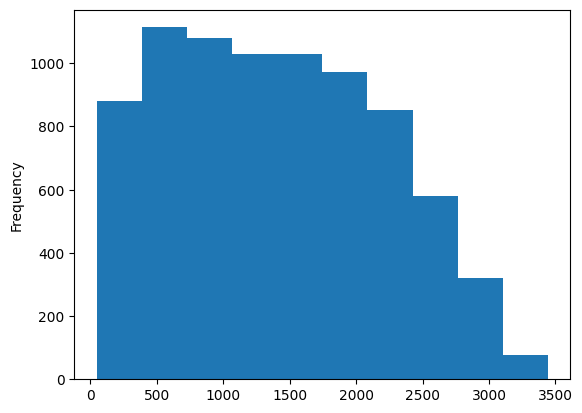

In [23]:
df['MP'].plot(kind='hist')

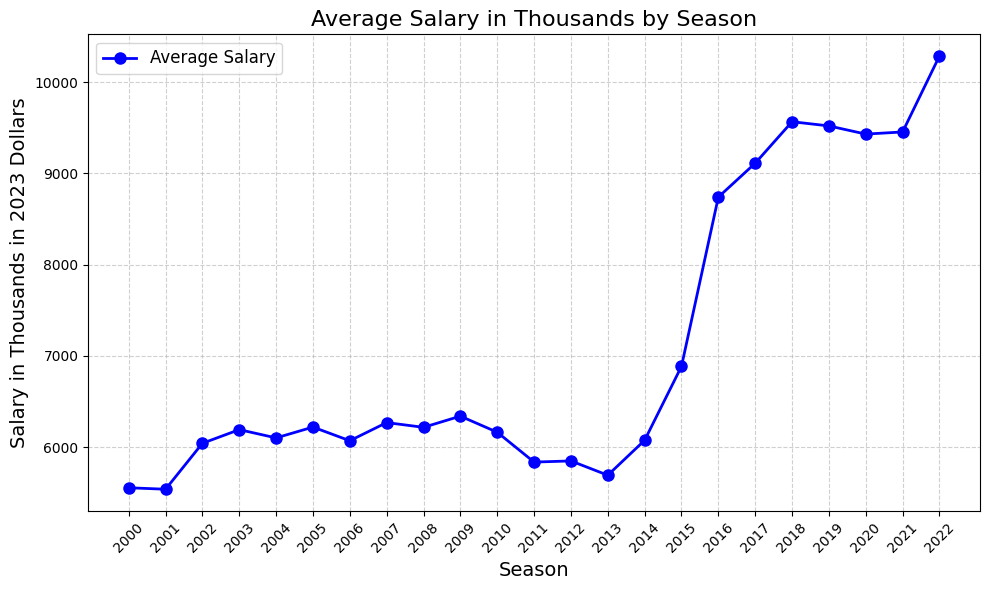

In [24]:
import matplotlib.pyplot as plt

# Group by season and calculate the mean salary
seasonal_salary_mean = df.groupby('Season')['salary'].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with a line plot
seasonal_salary_mean.plot(kind='line', ax=ax, color='b', marker='o', linestyle='-', linewidth=2, markersize=8)

# Set x-axis ticks and labels
ax.set_xticks(range(2000, 2023, 1))
ax.set_xticklabels(range(2000, 2023, 1), rotation=45)

# Add a title and labels
ax.set_title("Average Salary in Thousands by Season", fontsize=16)
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Salary in Thousands in 2023 Dollars', fontsize=14)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.6)

# Customize the legend
ax.legend(['Average Salary'], loc='upper left', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


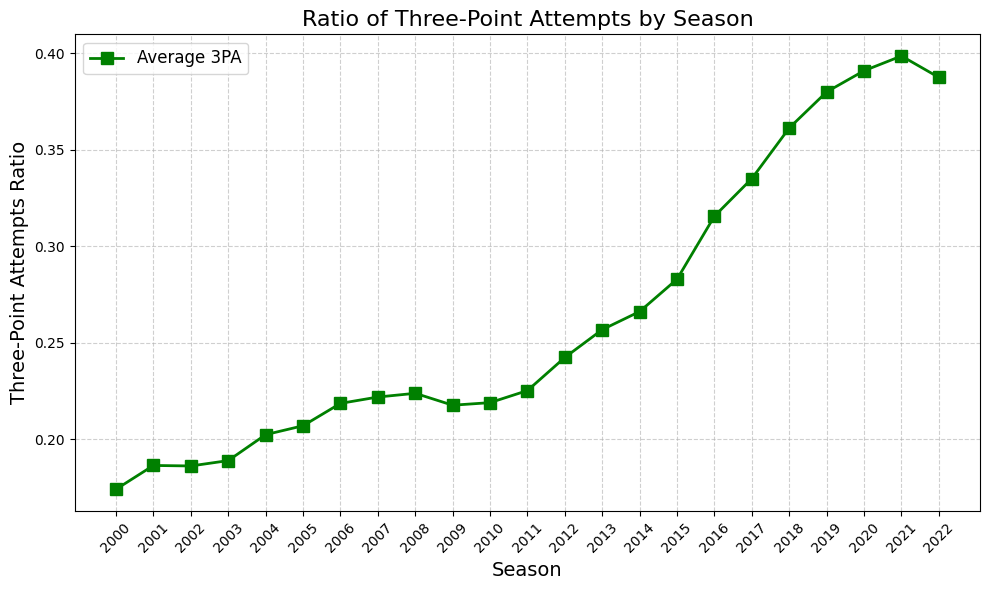

In [25]:
import matplotlib.pyplot as plt

# Group by season and calculate the mean three-point attempts
all_sea = df.groupby('Season').sum()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with a line plot
(all_sea['3PA'] / all_sea['FGA']).plot(kind='line', ax=ax, color='g', marker='s', linestyle='-', linewidth=2, markersize=8)

# Set x-axis ticks and labels
ax.set_xticks(range(2000, 2023, 1))
ax.set_xticklabels(range(2000, 2023, 1), rotation=45)

# Add a title and labels
ax.set_title("Ratio of Three-Point Attempts by Season", fontsize=16)
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Three-Point Attempts Ratio', fontsize=14)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.6)

# Customize the legend
ax.legend(['Average 3PA'], loc='upper left', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


# Model

In [26]:
list(df.columns)

['Season',
 'Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Trend',
 'name',
 'position',
 'salary',
 'season',
 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'season_2021',
 'season_2022',
 'team_BOS',
 'team_BRK',
 'team_CHA',
 'team_CHH',
 'team_CHI',
 'team_CHO',
 'team_CLE',
 'team_DAL',
 'team_DEN',
 'team_DET',
 'team_GSW',
 'team_HOU',
 'team_IND',
 'team_LAC',
 'team_LAL',
 'team_MEM',
 'team_MIA',
 'team_MIL',
 'team_MIN',
 'team_NJN',
 'team_NOH',
 'team_NOK',
 'team_NOP',
 'team_NYK',
 'team_OKC',
 'team_ORL',
 'team_PHI',

In [27]:
# baseline model: all stats and this year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'season_2021',
 'season_2022',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020',
 '3PPerMPxseason_2021',
 '3PPerMPxseason_2022',
       ]


#ThreePointersMade/Seconds

X = df[independent_vars]  # Independent variables
y = df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     53.47
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:50:59   Log-Likelihood:                -80509.
No. Observations:                7934   AIC:                         1.611e+05
Df Residuals:                    7882   BIC:                         1.615e+05
Df Model:                          51                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5385.4737    625.749     -8.606      0.000   -6611.920   -4159.028
GS                     77.4573      2.870     26.984      0.000      71.831      83.083
3PPerMP              3.006e+04   1.19e+04      2.528      0.011    6756.048    5.34e+04
PTSPerMP             1.583e+04    846.538     18.704      0.000    1.42e+04    1.75e+04
TRBPerMP             2.392e+04   1449.079     16.506      0.000    2.11e+04    2.68e+04
ASTPerMP             2.927e+04   2049.870     14.281      0.000    2.53e+04    3.33e+04
PFPerMP             -2.018e+04   2545.212     -7.927      0.000   -2.52e+04   -1.52e+04
STLPerMP            -2.966e+04   5928.732     -5.003      0.000   -4.13e+04    -1.8e+04
season_2001          -199.7792    487.561     -0.410      0.682   -1155.382     755.823
season_2002           158.4344    529.405      0.299      0.765    -879.180    1196.049
season_2003           384.1240    518.215      0.741      0.459    -631.560    1399.808
season_2004           493.1151    530.164      0.930      0.352    -545.988    1532.218
season_2005           623.1828    495.560      1.258      0.209    -348.096    1594.462
season_2006          -198.0813    484.964     -0.408      0.683   -1148.593     752.430
season_2007          -255.8777    525.927     -0.487      0.627   -1286.677     774.921
season_2008          -220.1885    532.002     -0.414      0.679   -1262.894     822.517
season_2009          -411.9170    535.466     -0.769      0.442   -1461.411     637.577
season_2010          -430.9562    511.917     -0.842      0.400   -1434.295     572.383
season_2011          -283.9259    477.800     -0.594      0.552   -1220.397     652.546
season_2012          -809.5522    499.666     -1.620      0.105   -1788.880     169.775
season_2013          -677.4370    498.399     -1.359      0.174   -1654.281     299.407
season_2014          -705.1886    534.108     -1.320      0.187   -1752.021     341.644
season_2015          -540.6103    604.382     -0.894      0.371   -1725.178     643.957
season_2016           634.3871    722.054      0.879      0.380    -780.813    2049.587
season_2017            68.2380    774.775      0.088      0.930   -1450.294    1586.770
season_2018            -8.0518    904.707     -0.009      0.993   -1781.245    1765.141
season_2019           -19.8092    906.076     -0.022      0.983   -1795.686    1756.068
season_2020          -924.7794    846.104     -1.093      0.274   -2583.114     733.555
season_2021         -1669.2421    895.273     -1.865      0.062   -3423.945      85.461
season_2022          -949.6788    902.339     -1.052      0.293   -2718.231     818.873
3PPerMPxseason_2001 -3451.7227   1.64e+04     -0.210      0.834   -3.56e+04    2.87e+04
3PPerMPxseason_2002  1.355e+04   1.97e+04      0.689      0.491    -2.5e+04    5.21e+04
3PP

In [28]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}       &      salary      & \textbf{  R-squared:         } &     0.381   \\
\textbf{Model:}               &       OLS        & \textbf{  Adj. R-squared:    } &     0.377   \\
\textbf{Method:}              &  Least Squares   & \textbf{  F-statistic:       } &     53.47   \\
\textbf{Date:}                & Wed, 29 Nov 2023 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                &     05:50:59     & \textbf{  Log-Likelihood:    } &   -80509.   \\
\textbf{No. Observations:}    &        7934      & \textbf{  AIC:               } & 1.611e+05   \\
\textbf{Df Residuals:}        &        7882      & \textbf{  BIC:               } & 1.615e+05   \\
\textbf{Df Model:}            &          51      & \textbf{                     } &             \\
\textbf{Covariance Type:}     &       HC1        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
            

In [29]:
df[['GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].corr()

,GS,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
GS,1.000000,0.058860,0.351831,0.038653,0.211098,-0.355445,0.053883
3PPerMP,0.058860,1.000000,-0.303038,-0.506971,0.251629,-0.453816,0.065410
PTSPerMP,0.351831,-0.303038,1.000000,0.341970,0.097837,-0.028569,-0.016986
TRBPerMP,0.038653,-0.506971,0.341970,1.000000,-0.437719,0.457986,-0.209711
ASTPerMP,0.211098,0.251629,0.097837,-0.437719,1.000000,-0.394985,0.399617
PFPerMP,-0.355445,-0.453816,-0.028569,0.457986,-0.394985,1.000000,-0.119145
STLPerMP,0.053883,0.065410,-0.016986,-0.209711,0.399617,-0.119145,1.000000


In [30]:
# model2: all stats and last year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'season_2021',
 'season_2022',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020',
 '3PPerMPxseason_2021',
 '3PPerMPxseason_2022',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['next_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['next_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 49
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       next_year_salary   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     70.04
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:51:00   Log-Likelihood:                -64679.
No. Observations:                6391   AIC:                         1.295e+05
Df Residuals:                    6341   BIC:                         1.298e+05
Df Model:                          49                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7403.8167    707.096    -10.471      0.000   -8789.699   -6017.935
GS                     84.9168      3.001     28.298      0.000      79.035      90.798
3PPerMP              3.676e+04   1.41e+04      2.609      0.009    9142.154    6.44e+04
PTSPerMP             2.154e+04    883.850     24.367      0.000    1.98e+04    2.33e+04
TRBPerMP             2.707e+04   1597.435     16.945      0.000    2.39e+04    3.02e+04
ASTPerMP              2.92e+04   2141.427     13.634      0.000     2.5e+04    3.34e+04
PFPerMP             -2.622e+04   2998.639     -8.744      0.000   -3.21e+04   -2.03e+04
STLPerMP            -2.005e+04   6725.279     -2.981      0.003   -3.32e+04   -6869.355
season_2001          -517.3600    558.973     -0.926      0.355   -1612.927     578.207
season_2002            70.3124    573.108      0.123      0.902   -1052.959    1193.584
season_2003           354.4270    541.450      0.655      0.513    -706.795    1415.649
season_2004           585.2341    556.435      1.052      0.293    -505.358    1675.826
season_2005           224.6516    530.038      0.424      0.672    -814.204    1263.507
season_2006          -354.0406    537.779     -0.658      0.510   -1408.068     699.986
season_2007          -801.5700    550.282     -1.457      0.145   -1880.103     276.963
season_2008          -562.6291    576.321     -0.976      0.329   -1692.197     566.939
season_2009          -974.3530    578.336     -1.685      0.092   -2107.871     159.165
season_2010          -789.4416    536.021     -1.473      0.141   -1840.023     261.140
season_2011          -509.2139    529.137     -0.962      0.336   -1546.303     527.875
season_2012         -1285.1634    547.903     -2.346      0.019   -2359.034    -211.293
season_2013         -1157.3917    568.343     -2.036      0.042   -2271.324     -43.459
season_2014         -1133.6484    627.013     -1.808      0.071   -2362.572      95.275
season_2015           368.0038    769.401      0.478      0.632   -1139.994    1876.001
season_2016          1321.1281    863.950      1.529      0.126    -372.182    3014.438
season_2017          -428.9202    905.609     -0.474      0.636   -2203.882    1346.042
season_2018         -1087.7715   1049.561     -1.036      0.300   -3144.874     969.331
season_2019         -1436.8471    991.577     -1.449      0.147   -3380.303     506.609
season_2020         -1749.8059    896.625     -1.952      0.051   -3507.158       7.546
season_2021         -2090.1935    985.130     -2.122      0.034   -4021.012    -159.375
season_2022          3.194e-11    7.1e-11      0.450      0.653   -1.07e-10    1.71e-10
3PPerMPxseason_2001  1.381e+04   1.93e+04      0.717      0.474    -2.4e+04    5.16e+04
3PPerMPxseason_2002   2.46e+04   2.14e+04      1.152      0.249   -1.73e+04    6.65e+04
3PP

In [31]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}       & next\_year\_salary & \textbf{  R-squared:         } &     0.472   \\
\textbf{Model:}               &        OLS         & \textbf{  Adj. R-squared:    } &     0.467   \\
\textbf{Method:}              &   Least Squares    & \textbf{  F-statistic:       } &     70.04   \\
\textbf{Date:}                &  Wed, 29 Nov 2023  & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                &      05:51:00      & \textbf{  Log-Likelihood:    } &   -64679.   \\
\textbf{No. Observations:}    &         6391       & \textbf{  AIC:               } & 1.295e+05   \\
\textbf{Df Residuals:}        &         6341       & \textbf{  BIC:               } & 1.298e+05   \\
\textbf{Df Model:}            &           49       & \textbf{                     } &             \\
\textbf{Covariance Type:}     &        HC1         & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcc

In [32]:
# # model3: all stats and last year's salary with trend


# independent_vars = [
#     'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
#  'season_2021',
#   'season_2022',
#  '3PPerMPxTrend',
#      'Trend',
#        ]

# new_df = df.copy()
# new_df = new_df.dropna(subset=['last_year_salary'])

# #ThreePointersMade/Seconds

# X = new_df[independent_vars]  # Independent variables
# y = new_df['last_year_salary']  # Dependent variable

# # Adding a constant term for the intercept
# X = sm.add_constant(X)

# # Fitting the model
# model = sm.OLS(y, X).fit(cov_type='HC1')

# # Getting the summary of the model
# model_summary = model.summary()
# model_summary

In [33]:
# print(model.summary().as_latex())

In [34]:
# model5: all stats and this year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
# new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     290.0
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:51:00   Log-Likelihood:                -80553.
No. Observations:                7934   AIC:                         1.611e+05
Df Residuals:                    7924   BIC:                         1.612e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5283.0645    536.439     -9.848      0.000   -6334.466   -4231.663
GS               77.1514      2.872     26.861      0.000      71.522      82.781
3PPerMP        1.796e+04   5941.782      3.023      0.003    6316.939    2.96e+04
PTSPerMP       1.594e+04    845.327     18.860      0.000    1.43e+04    1.76e+04
TRBPerMP       2.441e+04   1453.271     16.796      0.000    2.16e+04    2.73e+04
ASTPerMP        2.99e+04   2054.777     14.553      0.000    2.59e+04    3.39e+04
PFPerMP       -1.938e+04   2491.303     -7.781      0.000   -2.43e+04   -1.45e+04
STLPerMP      -3.084e+04   5939.597     -5.192      0.000   -4.25e+04   -1.92e+04
3PPerMPxTrend  3938.2493    480.742      8.192      0.000    2996.013    4880.485
Trend           -58.2349     18.310     -3.181      0.001     -94.121     -22.348
==============================================================================
Omnibus:                     1655.519   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4041.683
Skew:                           1.155   Prob(JB):                         0.00
Kurtosis:                       5.625   Cond. No.                     3.96e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      salary      & \textbf{  R-squared:         } &     0.374   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.374   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     290.0   \\
\textbf{Date:}             & Wed, 29 Nov 2023 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}             &     05:51:00     & \textbf{  Log-Likelihood:    } &   -80553.   \\
\textbf{No. Observations:} &        7934      & \textbf{  AIC:               } & 1.611e+05   \\
\textbf{Df Residuals:}     &        7924      & \textbf{  BIC:               } & 1.612e+05   \\
\textbf{Df Model:}         &           9      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &       HC1        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} 

In [36]:
# model4: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['next_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['next_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       next_year_salary   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     358.8
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:51:00   Log-Likelihood:                -64742.
No. Observations:                6391   AIC:                         1.295e+05
Df Residuals:                    6381   BIC:                         1.296e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7537.5534    611.820    -12.320      0.000   -8736.698   -6338.409
GS               85.3645      3.027     28.203      0.000      79.432      91.297
3PPerMP        2.812e+04   6318.661      4.450      0.000    1.57e+04    4.05e+04
PTSPerMP       2.163e+04    885.606     24.422      0.000    1.99e+04    2.34e+04
TRBPerMP       2.774e+04   1606.120     17.270      0.000    2.46e+04    3.09e+04
ASTPerMP       2.965e+04   2156.886     13.747      0.000    2.54e+04    3.39e+04
PFPerMP       -2.535e+04   2953.222     -8.583      0.000   -3.11e+04   -1.96e+04
STLPerMP      -1.911e+04   6754.641     -2.829      0.005   -3.23e+04   -5868.630
3PPerMPxTrend  4799.3942    530.597      9.045      0.000    3759.443    5839.346
Trend           -76.4910     20.871     -3.665      0.000    -117.397     -35.585
==============================================================================
Omnibus:                      894.111   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1790.937
Skew:                           0.865   Prob(JB):                         0.00
Kurtosis:                       4.931   Cond. No.                     4.27e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & next\_year\_salary & \textbf{  R-squared:         } &     0.461   \\
\textbf{Model:}            &        OLS         & \textbf{  Adj. R-squared:    } &     0.460   \\
\textbf{Method:}           &   Least Squares    & \textbf{  F-statistic:       } &     358.8   \\
\textbf{Date:}             &  Wed, 29 Nov 2023  & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}             &      05:51:00      & \textbf{  Log-Likelihood:    } &   -64742.   \\
\textbf{No. Observations:} &         6391       & \textbf{  AIC:               } & 1.295e+05   \\
\textbf{Df Residuals:}     &         6381       & \textbf{  BIC:               } & 1.296e+05   \\
\textbf{Df Model:}         &            9       & \textbf{                     } &             \\
\textbf{Covariance Type:}  &        HC1         & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                     

In [38]:
# model6: all stats and this year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

     'position_PG', 'position_SG', 'position_SF', 'position_PF', #'position_C',


 '3PPerMPxPosition_PFxTrend',
 '3PPerMPxPosition_PGxTrend',
 '3PPerMPxPosition_SFxTrend',
 '3PPerMPxPosition_SGxTrend',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
# new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     174.1
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:51:00   Log-Likelihood:                -80381.
No. Observations:                7934   AIC:                         1.608e+05
Df Residuals:                    7916   BIC:                         1.609e+05
Df Model:                          17                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1027.6998    645.468     -1.592      0.111   -2292.795     237.395
GS                           69.5627      2.879     24.165      0.000      63.921      75.205
3PPerMP                    2.335e+04   5904.887      3.954      0.000    1.18e+04    3.49e+04
PTSPerMP                   1.515e+04    832.101     18.206      0.000    1.35e+04    1.68e+04
TRBPerMP                   1.149e+04   1757.329      6.538      0.000    8044.627    1.49e+04
ASTPerMP                   4.885e+04   2658.175     18.378      0.000    4.36e+04    5.41e+04
PFPerMP                   -2.497e+04   2537.781     -9.841      0.000   -2.99e+04      -2e+04
STLPerMP                  -1.551e+04   6036.841     -2.570      0.010   -2.73e+04   -3682.588
position_PG               -7880.9634    489.010    -16.116      0.000   -8839.404   -6922.522
position_SG               -3467.7666    358.839     -9.664      0.000   -4171.078   -2764.456
position_SF               -2642.1030    319.295     -8.275      0.000   -3267.909   -2016.297
position_PF               -1373.3014    230.974     -5.946      0.000   -1826.003    -920.600
3PPerMPxPosition_PFxTrend  1730.7205    729.653      2.372      0.018     300.627    3160.814
3PPerMPxPosition_PGxTrend  4356.3947    845.328      5.153      0.000    2699.583    6013.207
3PPerMPxPosition_SFxTrend  2035.4709    743.272      2.739      0.006     578.685    3492.257
3PPerMPxPosition_SGxTrend   760.0384    671.927      1.131      0.258    -556.914    2076.991
3PPerMPxTrend              1857.7061    746.198      2.490      0.013     395.185    3320.227
Trend                       -70.6330     17.849     -3.957      0.000    -105.617     -35.649
==============================================================================
Omnibus:                     1565.437   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3823.665
Skew:                           1.095   Prob(JB):                         0.00
Kurtosis:                       5.602   Cond. No.                     4.05e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}             &      salary      & \textbf{  R-squared:         } &     0.401   \\
\textbf{Model:}                     &       OLS        & \textbf{  Adj. R-squared:    } &     0.400   \\
\textbf{Method:}                    &  Least Squares   & \textbf{  F-statistic:       } &     174.1   \\
\textbf{Date:}                      & Wed, 29 Nov 2023 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                      &     05:51:00     & \textbf{  Log-Likelihood:    } &   -80381.   \\
\textbf{No. Observations:}          &        7934      & \textbf{  AIC:               } & 1.608e+05   \\
\textbf{Df Residuals:}              &        7916      & \textbf{  BIC:               } & 1.609e+05   \\
\textbf{Df Model:}                  &          17      & \textbf{                     } &             \\
\textbf{Covariance Type:}           &       HC1        & \textbf{                     } &             \\
\bottomru

In [40]:
# model6: all stats and this year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

     'position_PG', 'position_SG', 'position_SF', 'position_PF', #'position_C',


 '3PPerMPxPosition_PFxTrend',
 '3PPerMPxPosition_PGxTrend',
 '3PPerMPxPosition_SFxTrend',
 '3PPerMPxPosition_SGxTrend',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['next_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['next_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       next_year_salary   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     210.8
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:51:00   Log-Likelihood:                -64602.
No. Observations:                6391   AIC:                         1.292e+05
Df Residuals:                    6373   BIC:                         1.294e+05
Df Model:                          17                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -3327.8566    740.943     -4.491      0.000   -4780.078   -1875.636
GS                           78.3078      3.033     25.821      0.000      72.364      84.252
3PPerMP                    3.378e+04   6300.953      5.362      0.000    2.14e+04    4.61e+04
PTSPerMP                   2.069e+04    871.685     23.738      0.000     1.9e+04    2.24e+04
TRBPerMP                   1.574e+04   1962.310      8.023      0.000    1.19e+04    1.96e+04
ASTPerMP                   4.789e+04   2786.069     17.189      0.000    4.24e+04    5.33e+04
PFPerMP                   -3.098e+04   3025.681    -10.239      0.000   -3.69e+04    -2.5e+04
STLPerMP                  -3816.8435   6999.821     -0.545      0.586   -1.75e+04    9902.553
position_PG               -7861.2796    539.215    -14.579      0.000   -8918.122   -6804.437
position_SG               -3467.2762    404.614     -8.569      0.000   -4260.305   -2674.247
position_SF               -2723.1888    356.621     -7.636      0.000   -3422.153   -2024.225
position_PF               -1578.9882    252.281     -6.259      0.000   -2073.449   -1084.527
3PPerMPxPosition_PFxTrend  2749.7311    822.740      3.342      0.001    1137.191    4362.271
3PPerMPxPosition_PGxTrend  5757.5828    933.266      6.169      0.000    3928.416    7586.750
3PPerMPxPosition_SFxTrend  3310.1616    839.923      3.941      0.000    1663.942    4956.381
3PPerMPxPosition_SGxTrend  1947.1980    760.521      2.560      0.010     456.604    3437.792
3PPerMPxTrend              1612.4624    834.584      1.932      0.053     -23.292    3248.216
Trend                       -87.5943     20.262     -4.323      0.000    -127.308     -47.881
==============================================================================
Omnibus:                      835.784   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1683.038
Skew:                           0.815   Prob(JB):                         0.00
Kurtosis:                       4.914   Cond. No.                     4.37e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}             & next\_year\_salary & \textbf{  R-squared:         } &     0.484   \\
\textbf{Model:}                     &        OLS         & \textbf{  Adj. R-squared:    } &     0.483   \\
\textbf{Method:}                    &   Least Squares    & \textbf{  F-statistic:       } &     210.8   \\
\textbf{Date:}                      &  Wed, 29 Nov 2023  & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                      &      05:51:00      & \textbf{  Log-Likelihood:    } &   -64602.   \\
\textbf{No. Observations:}          &         6391       & \textbf{  AIC:               } & 1.292e+05   \\
\textbf{Df Residuals:}              &         6373       & \textbf{  BIC:               } & 1.294e+05   \\
\textbf{Df Model:}                  &           17       & \textbf{                     } &             \\
\textbf{Covariance Type:}           &        HC1         & \textbf{                     } &       

In [42]:
list(df.columns)

['Season',
 'Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Trend',
 'name',
 'position',
 'salary',
 'season',
 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'season_2021',
 'season_2022',
 'team_BOS',
 'team_BRK',
 'team_CHA',
 'team_CHH',
 'team_CHI',
 'team_CHO',
 'team_CLE',
 'team_DAL',
 'team_DEN',
 'team_DET',
 'team_GSW',
 'team_HOU',
 'team_IND',
 'team_LAC',
 'team_LAL',
 'team_MEM',
 'team_MIA',
 'team_MIL',
 'team_MIN',
 'team_NJN',
 'team_NOH',
 'team_NOK',
 'team_NOP',
 'team_NYK',
 'team_OKC',
 'team_ORL',
 'team_PHI',